In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: Load the dataset
file_path = "NFLX (1).csv"  # Update with correct path
df = pd.read_csv(file_path)



In [3]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Safe conversion
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

# STEP 2: Resample daily stock data to monthly (get last close of each month)
monthly_df = df['Close'].resample('MS').last().to_frame()  # MS = Month Start

# STEP 3: Handle missing values by interpolation
monthly_df['Value'] = monthly_df['Close'].interpolate(method='linear')
monthly_df.drop(columns='Close', inplace=True)  # Clean up


In [7]:
# STEP 4: 12-month Moving Average
monthly_df['Moving_Avg_12'] = monthly_df['Value'].rolling(window=12, min_periods=1).mean()

# STEP 5: Exponential Smoothing
monthly_df['Exp_Smooth_Alpha0.3'] = monthly_df['Value'].ewm(alpha=0.3).mean()

# STEP 6: Seasonal Decomposition (additive model, 12-month period)
if len(monthly_df) >= 24:
    decomposed = seasonal_decompose(monthly_df['Value'], model='additive', period=12)
    monthly_df['Trend'] = decomposed.trend
    monthly_df['Seasonal'] = decomposed.seasonal
    monthly_df['Residual'] = decomposed.resid
    monthly_df.dropna(inplace=True)
else:
    raise ValueError("Not enough data for seasonal decomposition (minimum 24 months required).")

# STEP 7: Holt-Winters Exponential Smoothing
hw_model = ExponentialSmoothing(
    monthly_df['Value'], trend='add', seasonal='add', seasonal_periods=12
)
hw_fit = hw_model.fit()
monthly_df['HoltWinters'] = hw_fit.fittedvalues

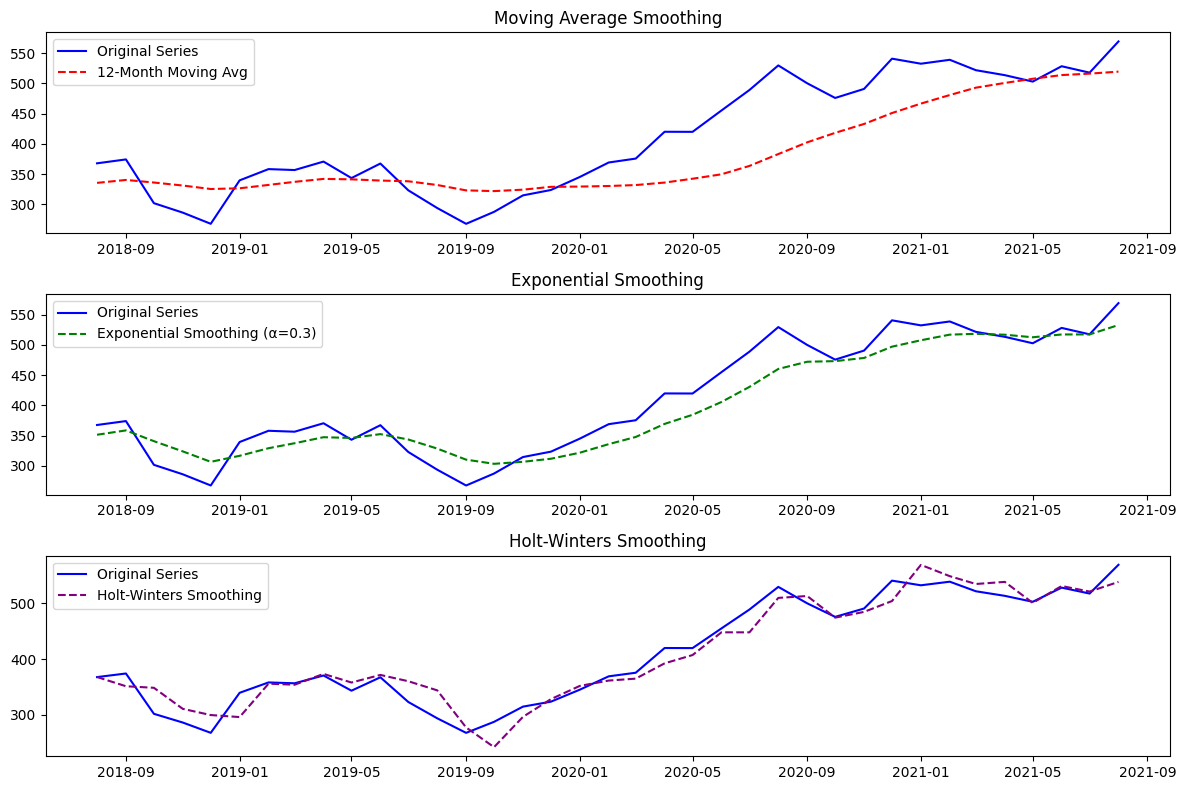

In [8]:
# STEP 8: Plotting all smoothing techniques
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(monthly_df['Value'], label="Original Series", color='blue')
plt.plot(monthly_df['Moving_Avg_12'], label="12-Month Moving Avg", color='red', linestyle='--')
plt.title("Moving Average Smoothing")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(monthly_df['Value'], label="Original Series", color='blue')
plt.plot(monthly_df['Exp_Smooth_Alpha0.3'], label="Exponential Smoothing (α=0.3)", color='green', linestyle='--')
plt.title("Exponential Smoothing")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(monthly_df['Value'], label="Original Series", color='blue')
plt.plot(monthly_df['HoltWinters'], label="Holt-Winters Smoothing", color='purple', linestyle='--')
plt.title("Holt-Winters Smoothing")
plt.legend()

plt.tight_layout()
plt.show()